In [27]:
# Imports.
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
#import matplotlib.ticker as mticker
#import matplotlib.colors as mcolor

# from scipy.stats import linregress
# from dotmap import DotMap

import aeon.io.api as aeon
#from aeon.analysis.movies import *
# from aeon.analysis.plotting import *
# from aeon.analysis.utils import *
# from aeon.io.video import *
# from aeon.schema.dataset import exp02
#import aeon.io.reader as _reader

### Recreate figures using datajoint pipeline

In [2]:
import datajoint as dj
from aeon.dj_pipeline import acquisition, lab, qc, report, subject, tracking
from aeon.dj_pipeline.analysis import in_arena, visit


[2022-07-14 04:24:48,443][INFO]: Connecting jaeronga@aeon-db2:3306
[2022-07-14 04:24:48,458][INFO]: Connected jaeronga@aeon-db2:3306


In [4]:
experiment_name = "exp0.2-r0"
duration_crit = 24  # in hours

subject_visits = (visit.VisitEnd & f'experiment_name="{experiment_name}"' & f'visit_duration > {duration_crit}').fetch(order_by='visit_duration', format='frame').reset_index()
subject_visits  # comparison between Chang's subject_visits df. visit_start timestamp is the same, but small difference in visit_end timestamp (Chang's version is ~4 early)

,experiment_name,subject,place,visit_start,visit_end,visit_duration
0,exp0.2-r0,BAA-1100700,environment,2022-02-23 14:21:25.550300,2022-02-25 16:00:50.076419,49.6568
1,exp0.2-r0,BAA-1100701,environment,2022-04-04 15:54:07.945059,2022-04-08 16:34:36.183650,96.6745
2,exp0.2-r0,BAA-1100699,environment,2022-03-29 13:11:37.277699,2022-04-04 09:16:51.086110,140.0870
3,exp0.2-r0,BAA-1100699,environment,2022-04-20 11:51:24.997630,2022-04-28 10:02:56.655809,190.1920
4,exp0.2-r0,BAA-1100702,environment,2022-05-03 11:08:12.660739,2022-05-12 09:21:42.411650,214.2250
5,exp0.2-r0,BAA-1100703,environment,2022-05-25 08:59:51.050459,2022-06-06 07:55:37.501309,286.9300


- In exp0.2-r0, there are 16 visits by 5 animals. 5 visits whose duration > 24 hr

In [20]:
# plot daily pellet count
pellet_df = pd.DataFrame() 
columns = ["food_patch_serial_number", "event_time"]

visit_dict = (visit.VisitEnd & f'experiment_name="{experiment_name}"' & f'visit_duration > {duration_crit}').fetch("subject", "visit_start", "visit_end", as_dict=True)

for _ in visit_dict: 
    subject, visit_start, visit_end = _["subject"], _["visit_start"], _["visit_end"]
    # print((subject, visit_start, visit_end))
    
    temp_df = (acquisition.FoodPatchEvent * acquisition.EventType \
    & f'experiment_name = "{experiment_name}"' \
    & 'event_type = "TriggerPellet"' \
    & f'event_time BETWEEN "{visit_start}" AND "{visit_end}"'    
    ).fetch(format="frame").reset_index()[columns]
    
    temp_df["subject"] = '_'.join([subject, visit_start.strftime("%m%d")])
    temp_df["day"] = temp_df["event_time"].apply(lambda x: pd.Timestamp(x).date())
    temp_df["day"] -= temp_df["day"][0]
    temp_df["day"] = temp_df["day"].dt.days
    temp_df.set_index("event_time", inplace=True)
    pellet_df = pd.concat([pellet_df, temp_df])


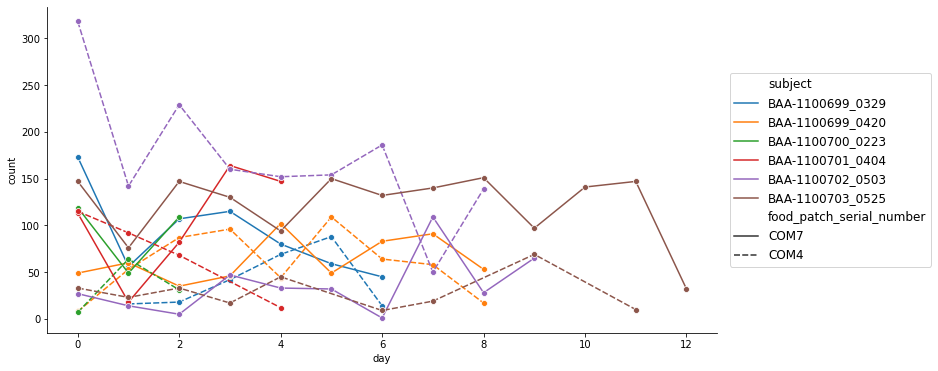

In [26]:
pellet_count = (
    pellet_df.groupby(["subject", "day", "food_patch_serial_number"])
    .size()
    .reset_index(name="count")
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    data=pellet_count,
    x="day",
    y="count",
    hue="subject",
    style="food_patch_serial_number",
    ax=ax,
    marker="o",
)

ax.legend(loc='center left', 
        bbox_to_anchor=(1.01, 0.5), prop={'size': 12},
        # markerscale=40,
) 
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [29]:
pellet_count
# pellet_count.to_csv('pellet_count_dj.csv')

,subject,day,food_patch_serial_number,count
0,BAA-1100699_0329,0,COM7,173
1,BAA-1100699_0329,1,COM4,16
2,BAA-1100699_0329,1,COM7,56
3,BAA-1100699_0329,2,COM4,18
4,BAA-1100699_0329,2,COM7,107
...,...,...,...,...
82,BAA-1100703_0525,9,COM7,97
83,BAA-1100703_0525,10,COM7,141
84,BAA-1100703_0525,11,COM4,10
85,BAA-1100703_0525,11,COM7,147


- Numbers are slightly off compared to Chang's code. This needs to be checked.

In [ ]:
# plot daily subject weight
weights = pd.DataFrame()

for i in range(len(subject_visits)):
    if i == 0:  # compute subj weight from raw weights
        weight = compute_subj_weight(i)
    else:
        weight = get_data(exp02.Nest.WeightSubject, i)
        weight.rename(columns={"value": "weight"}, inplace=True)
    weights = pd.concat([weights, weight])

weights["day"] = (weights.index.date - weights["day"]).dt.days

# remove outliers from scale misbehaviour
weights = weights[weights.weight.between(24, 50)]
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x="day", y="weight", hue="id", data=weights, ax=ax)